In [2]:
''' Import packages. '''
# Time packages
import cftime, datetime, time
# Numerical analysis packages
import numpy as np, random, scipy
# Local data storage packages
import dill, os, pickle
# Data structure packages
import pandas as pd, xarray as xr
# Visualization tools
import cartopy.crs as ccrs, matplotlib, matplotlib.pyplot as plt

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

### Methods

#### Main method (`tc_storage`)

In [55]:
def tc_storage(model, experiment, year_range, storm_type, random_num=None, benchmarking=True):
    
    ''' 
    Function to build unified xArray Dataset to hold model and track data for tracked TCs in a given model and experiment.
    
    Input(s):
    - model (str):                name of model to access (typically "AM2.5" or "HIRAM")
    - experiment (str):           name of experiment to access (typically "control", "ktc", "plus2K", etc.)
    - year_range (tuple of ints): 2-element tuple with a start and end year
    - storm_type (str):           type of storm to evaluate from TC tracks data ("TS" for all storms or "C15w" for hurricanes)
    - benchmarking (bool):        boolean to enable time benchmarking
    Output(s):
    - dirs (tuple):               2-element tuple with pathnames for the model- and experiment-specific GCM and track directories.
    '''
    
    if benchmarking:
        start = time.time()
    
    # Define paths to model- and experiment-specific data.
    model_dir, track_dir = dirnames(model, experiment)
    
    if benchmarking:
        print('Directory access time: {0:.3f} s'.format(time.time() - start))
        lap = time.time()
    
    # Retrieve tracked TCs over the specified year range. Note: year_range re-specified to ensure increasing order in tuple.
    storm_track_output = retrieve_tracked_TCs(track_dir, storm_type, year_range=(min(year_range), max(year_range)))
    
    if benchmarking:
        print('Track access time: {0:.3f} s'.format(time.time() - lap))
        lap = time.time()
    
    # Retrieve model data over specified year range. 
    # This is here so that both TC-specific and associated global model data can be analyzed together.
    model_output = retrieve_model_data(model_dir, year_range=(min(year_range), max(year_range)), output_type='atmos_month', benchmarking=benchmarking)
    
    if benchmarking:
        print('Model output access time: {0:.3f} s'.format(time.time() - lap))
        lap = time.time()
    
    # Retrieve model data specified to tracked TCs.
    # Note: default model output type is 'atmos_4xdaily'. If 'output_type' matches 'model_output', then access pre-loaded data from 'model_output'.
    storm_model_output = retrieve_model_TCs(model_dir, (min(year_range), max(year_range)), storm_track_output, 
                                            model_output, output_type='atmos_4xdaily', random_num=random_num)
    
    if benchmarking:
        print('TC accessing output access time: {0:.3f} s'.format(time.time() - lap))
        lap = time.time()
    
    # Get radius for each storm to use for future normalization
    storm_model_output = add_radius(storm_model_output, benchmarking=benchmarking)
    
    if benchmarking:
        print('Radius derivation computation time: {0:.3f} s'.format(time.time() - lap))
        lap = time.time()
    
    if benchmarking:
        print('Total runtime: {0:.3f} s'.format(time.time() - start))
    
    return storm_track_output, model_output, storm_model_output

#### Path name storage (`dirnames`)

In [4]:
def dirnames(model, experiment):

    ''' 
    Function to store pathnames for selected models and experiments. 
    
    Input(s):
    - model (str):  name of model to access (typically "AM2.5" or "HIRAM").
    Output(s):
    - dirs (tuple): 2-element tuple with pathnames for the model- and experiment-specific GCM and track directories.
    '''
    
    # Define experiment-specific pathnames
    experiments = {'control': {'AM2.5': 'CTL1990s_tigercpu_intelmpi_18_540PE',
                               'HIRAM': 'CTL1990s_v201910_tigercpu_intelmpi_18_540PE'},
                   'ktc': {'AM2.5': 'CTL1990s_killtc13-13-15_tigercpu_intelmpi_18_540PE',
                           'HIRAM': 'CTL1990s_v201910_killtc13-13-15_tigercpu_intelmpi_18_540PE'}}
    # Model directories
    model_dirs = {'AM2.5': {'control': '/tigress/wenchang/analysis/TC/AM2.5/CTL1990s_tigercpu_intelmpi_18_540PE/model_out/POSTP',
                            'ktc': '/tigress/wenchang/analysis/TC/AM2.5ktc2/CTL1990s_killtc13-13-15_tigercpu_intelmpi_18_540PE/modelout/POSTP'},
                  'HIRAM': {'control': '/tigress/wenchang/analysis/TC/HIRAM/CTL1990s_v201910_tigercpu_intelmpi_18_540PE/model_out/POSTP',
                            'ktc': '/tigress/wenchang/analysis/TC/HIRAMktc2/CTL1990s_v201910_killtc13-13-15_tigercpu_intelmpi_18_540PE/modelout/POSTP'}}
    # Track directories
    # Potential issue: ask Wenchang about using track .nc files in the same parent directory tree as the model data
    track_dirs = {'AM2.5': {'control': '/tigress/wenchang/MODEL_OUT/AM2.5/CTL1990s_tigercpu_intelmpi_18_540PE/analysis_lmh/cyclones_gav_ro110_1C_330k',
                            'ktc': '/tigress/wenchang/MODEL_OUT/AM2.5ktc2/CTL1990s_killtc13-13-15_tigercpu_intelmpi_18_540PE/analysis_lmh/cyclones_gav_ro110_1C_330k'},
                  'HIRAM': {'control': '/tigress/wenchang/MODEL_OUT/HIRAM/CTL1990s_v201910_tigercpu_intelmpi_18_540PE/analysis_lmh/cyclones_gav_ro110_2p5C_330k',
                            'ktc': '/tigress/wenchang/MODEL_OUT/HIRAMktc2/CTL1990s_v201910_killtc13-13-15_tigercpu_intelmpi_18_540PE/analysis_lmh/cyclones_gav_ro110_1C_330k'}}

    dirs = (model_dirs[model][experiment], track_dirs[model][experiment])
    
    return dirs

#### Parser for Lucas Harris' output tracks (`lmh_parser`)

In [5]:
def lmh_parser(path):
    
    ''' 
    This method parses through text files from Lucas Harris' run outputs (held in directories titled 'analysis_lmh') 
    and produces an output DataFrame. 
    
    Input(s):
    - path (str):            path containing raw tracker data from Lucas Harris' runs.
    Output(s):
    - df (Pandas DataFrame): Pandas DataFrame containing tracked TC data
    '''
    
    # Create file object instance
    fobj = open(path, 'r').readlines()
    # Initialize dictionary to hold data
    data = {'storm_num': {}}
    # Initialize storm counter
    count = 1
    # Iterate through text file
    for line in fobj:
        # Extract information from the line
        content = line.strip()
        # Creates new storm-specific dict in the parent dict. The '+++' demarcates a new storm.
        if '+++' in line:
            storm_num = '{0:04d}'.format(count)
            data['storm_num'][storm_num] = {'storm_id': [], 'time': [], 'lon': [], 'lat': [], 'slp': [], 'max_wnd': [], 'flag': []}
            count += 1
        # Populates the storm-specific dict
        else:
            storm_num = '{0:04d}'.format(count-1) 
            tc_info = [x for x in content.split(' ') if x]
            year = tc_info[0][0:4] # get 4-digit year
            data['storm_num'][storm_num]['storm_id'].append('{0}-{1:04d}'.format(year, count-1))
            data['storm_num'][storm_num]['time'].append(tc_info[0])
            data['storm_num'][storm_num]['lon'].append(tc_info[1])
            data['storm_num'][storm_num]['lat'].append(tc_info[2])
            data['storm_num'][storm_num]['slp'].append(tc_info[3])
            data['storm_num'][storm_num]['max_wnd'].append(tc_info[4])
            data['storm_num'][storm_num]['flag'].append(tc_info[5])
    
    try:
        # Converts the dictionary into a DataFrame
        df = pd.concat({k: pd.DataFrame(v).T for k, v in data.items()}, axis=1)['storm_num']
        df = df.explode(df.columns.to_list()).reset_index().rename(columns={'index': 'storm_num'})
        # Re-cast column data types
        df = df.astype({'lon': 'float', 'lat': 'float', 'slp': 'float', 'max_wnd': 'float', 'flag': 'float'})
    except:
        df = pd.DataFrame(columns=['storm_id', 'time', 'lon', 'lat', 'slp', 'max_wnd', 'flag'])
    
    ''' DataFrame refinement. '''
    # Remove cold-core data points (flag == -1)
    df = df.loc[df['flag'] != -1].reset_index(drop=True)
    # Convert timestamps to datetime objects
    df['time'] = pd.to_datetime(df['time'], format='%Y%m%d%H')
    
    return df

#### Coordinate-to-distance method (`coords_to_dist`)

In [6]:
def coords_to_dist(a, b):
    ''' Convert coordinates to distance in meters. '''
    
    R = 6371e3
    
    lon_a, lat_a = np.array(a)*np.pi/180
    lon_b, lat_b = np.array(b)*np.pi/180
    
    dlon, dlat = lon_b - lon_a, lat_b - lat_a
    
    a = np.sin(dlat/2)**2 + np.cos(lat_a)*np.cos(lat_b)*np.sin(dlon/2)**2    
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    distance = R*c
    
    return distance

#### Retrieve tracked TCs (`retrieve_tracked_TCs`)

In [7]:
def retrieve_tracked_TCs(dirname, storm_type, year_range):

    '''
    Function to collect tracked TC data and add derived data, such as duration and storm speed.
    
    Input(s):
    - dirname (str):              name of directory containing files of interest
    - storm_type (str):           type of storm to evaluate from TC tracks data ("TS" for all storms or "C15w" for hurricanes)
    - year_range (tuple of ints): 2-element tuple with a start and end year
    Output(s):
    - data (Pandas DataFrame):    Pandas DataFrame with tracked TC data
    '''
    
    ''' File collection. '''
    # Get filenames for all files within the specified directory 
    # Filenames will correspond to the determined storm type
    fnames = [[os.path.join(dirname, file, 'Harris.TC', f) for f in os.listdir(os.path.join(dirname, file, 'Harris.TC')) 
               if '{0}.world'.format(storm_type) in f]
               for file in sorted(os.listdir(dirname))]
    # Compress 2D list to 1D list
    fnames = [item for sublist in fnames for item in sublist]

    # Select files with dates within 'year_range'
    # Note: the '+ 1900' is added because tracked TCs are on the 2000 year range, whereas model output is on the 100 year range
    fnames = [f for f in fnames 
              if min(year_range) + 1900 <= pd.to_datetime(f.split('.')[-2].split('-')[0]).year < max(year_range) + 1900]
    
    # Concatenate all tracked TC data from the filename list
    data = pd.concat([lmh_parser(os.path.join(dirname, fname)) for fname in fnames])
    
    ''' Derived track-based data algorithm. Storm-specific derived properties will be generated in here. '''
    
    # Initialize empty duration column to populate iteratively
    data[['duration', 'speed', 'direction']] = np.nan
    # Initialize list to populate iteratively for each storm, then concatenate
    storms = []
    # Iterate through each unique storm (identify by 'storm_id') and get duration
    for storm_id in data['storm_id'].unique():
        # Define iterand storm
        storm = data.loc[data['storm_id'] == storm_id].copy().reset_index(drop=True)
        
        ''' Duration derivation. '''
        # Get difference between minimum and maximum timestamps
        dt = (storm['time'].max() - storm['time'].min())
        # Convert difference timedelta into hours
        dt = dt.days + dt.seconds/86400
        # Add duration to the outer DataFrame for the corresponding storm
        data.loc[data['storm_id'] == storm_id, 'duration'] = dt
        # Re-define iterand storm to incorporate duration
        storm = data.loc[data['storm_id'] == storm_id].copy().reset_index(drop=True)
        
        ''' Velocity (speed, direction) derivation. '''
        # Initialize dictionary for preliminary storage. Will be reassigned into the DataFrame by the join() method using time as the matching criterion.
        velocity = {'time': [storm.iloc[0]['time']], 'speed': [np.nan], 'direction': [np.nan]}
        # Iterate over all of the iterand storm timestamps
        for i in range(1, len(storm)):
            # Define coordinates for two points considered (i, i-1)
            lon_a, lat_a = [storm.iloc[i-1]['lon'], storm.iloc[i-1]['lat']]
            lon_b, lat_b = [storm.iloc[i]['lon'], storm.iloc[i]['lat']]
            # Determine timedelta between points (i, i-1)
            dt = storm.iloc[i]['time'] - storm.iloc[i-1]['time']
            # Derive speed (distance / time in m s^-1)
            speed = coords_to_dist((lon_b, lat_b), (lon_a, lat_a))/dt.seconds
            # Get changes in longtiude and latitude
            dlon, dlat = lon_b - lon_a, lat_b - lat_a
            # Derive direction relative to north (range of 0 to 360)
            direction = 180*np.arctan(dlon/dlat)/np.pi % 360
            # Append quantities to the 'velocity' dictionary
            velocity['time'].append(storm.iloc[i]['time'])    
            velocity['speed'].append(speed)    
            velocity['direction'].append(direction)
        # Build DataFrame
        velocity = pd.DataFrame(velocity)
        # Re-cast time column as a datetime object
        velocity['time'] = pd.to_datetime(velocity['time'])
        # Merge the storm and velocity DataFrames
        storm = storm.merge(velocity, how='left', on='time', suffixes=['_x', None]).drop(columns={'speed_x', 'direction_x'}).reset_index(drop=True)
        # Append to the list for future concatenation
        storms.append(storm)
        
    # Concatenate DataFrames
    data = pd.concat(storms)   
    # Rename columns for future addition into xArray Dataset, and reset index
    data = data.rename(columns={'lon': 'center_lon', 'lat': 'center_lat', 'flag': 'core_temp', 'slp': 'min_slp'}).reset_index(drop=True)
        
    return data

#### Get model data (`pull_gcm_data`)

In [8]:
def pull_gcm_data(dirname, year, output_type):
    
    ''' Method to read data for given parameters. '''
    
    # Get filenames for corresponding files
    filename = '{0:04d}0101.{1}.nc'.format(year, output_type)
    try:
        fname = os.path.join(dirname, filename)
        # Retrieve data
        data = xr.open_dataset(fname)
    except:
        return None
    
    return data

#### Retrieve GCM data (`retrieve_model_data`)

In [56]:
def retrieve_model_data(dirname, year_range, output_type='atmos_month', benchmarking=False):
    
    '''
    Method to open experiment-specific GCM output data for a specified year range and model output type.
    
    Input(s):
    - dirname (str):            directory name for the given model and experiment type.
    - year_range (tuple, list): tuple or list (minimum of 2 items) containing year range for desired data.
    - output_type (str):        string denoting GCM output desired.
    Output(s):
    - data (xArray Dataset):    xArray Dataset containing concatenated data for the year range selected.
    '''
    
    if benchmarking:
        start = time.time()
    
    # Identifier substring definition. This will be used for splitting the filename for identification purposes.
    substring = '0101.'
    # Access parent directory with experiment-specific model data and list directories corresponding to year range
    files = [os.path.join(dirname, file) for file in os.listdir(dirname) for year in range(min(year_range), max(year_range)) 
             if str(year) in file.split(substring)[0] and output_type in file]
    # Store file data into an xArray Dataset.
    # Note: benchmarking showed ~1.5 s for opening 4 files using 'open_mfdataset', and at least 10x longer using 'open_dataset' + 'xr.concat'
    data = xr.open_mfdataset(files)
    
    if benchmarking:
        print('\t Model data retrieval time: {0:.3f} s'.format(time.time() - start))
    
    return data

#### Pull TC model data (`retrieve_model_TCs`)

In [10]:
def retrieve_model_TCs(dirname, year_range, storms, model_output=None, output_type='atmos_4xdaily', extent=10, random_num=None):
    
    # Check to see if model_output (previously-access model data) is the same output type as desired for TCs. If so, pull from that Dataset.
    if model_output and output_type == model_output.attrs['filename'].split('.')[0]:
        data = model_output
    else:
        # Identifier substring definition. This will be used for splitting the filename for identification purposes.
        substring = '0101.'
        # Access parent directory with experiment-specific model data and list directories corresponding to year range
        files = [os.path.join(dirname, file) for file in os.listdir(dirname) for year in range(min(year_range), max(year_range)) 
                 if str(year) in file.split(substring)[0] and output_type in file]
        # Store file data into an xArray Dataset.
        data = xr.open_mfdataset(files)
    
    # Initialize list to hold each storm Dataset for future concatenation
    storms_xr = []
    # Define range of storm IDs to iterate over. 
    # If 'random_num' is defined, get that many randomized storms. Otherwise, get all.
    storm_ids = random.sample(list(storms['storm_id'].unique()), random_num) if random_num else storms['storm_id'].unique()
    # Access model data that are specific to each tracked TC.
    for storm_id in storm_ids:
        # Pull tracked TC data relative to storm
        storm = storms.loc[storms['storm_id'] == storm_id]
        # Initialize list to hold Dataset entries for each storm timestamp
        storm_xr = []
        # Iterate over each storm Series
        for i in range(0, len(storm)):                   
            # Convert from tracked TC timestamp convention (datetime) to model timestamp convention (cftime DatetimeNoLeap)
            cf_timestamp = cftime.DatetimeNoLeap(year=storm.iloc[i]['time'].year-1900, month=storm.iloc[i]['time'].month, 
                                                 day=storm.iloc[i]['time'].day, hour=storm.iloc[i]['time'].hour)
            # Take snapshot of data at this timestamp
            # Note 1: this is where the connection between track and model output data happens
            # Note 2: any operations beyond selection result in active computation, which disrupts the 'lazy' approach
            snapshot = data.sel(time=cf_timestamp)
            # Get iterand information to append to Dataset for the given timestamp
            snapshot[['center_lon', 'center_lat', 'min_slp', 
                      'max_wnd', 'core_temp', 'speed', 'heading']] = [storm.iloc[i]['center_lon'], storm.iloc[i]['center_lat'], 
                                                                      storm.iloc[i]['min_slp'], storm.iloc[i]['max_wnd'], 
                                                                      storm.iloc[i]['core_temp'], storm.iloc[i]['speed'], storm.iloc[i]['direction']]  
            # Append to list
            storm_xr.append(snapshot)
        # Concatenate into unified Dataset for a storm
        storm_xr = xr.concat(storm_xr, dim='time')
        # Assign storm identifier (storm_id)
        # Note: to select specific storm from concatenated Dataset, use command as follows:
        #       storms.where(storms['storm_id'] == <storm_id>, drop=True)
        storm_xr['storm_id'] = storm_id
    
        ''' Spatial clipping - only at maximum intensity to save computation time. '''
        # Grab storm at timestamp with maximum wind speed
        # Calling this 'lifetime maximum intensity', or 'LMI', to use terminology from Wing et al, 2016 (10.1175/JCLI-D-18-0599.1)
        lmi = storm_xr.where(storm_xr['max_wnd'] == storm_xr['max_wnd'].max(), drop=True)
        # If multiple wind maxima are detected, get the storm with lower pressure
        lmi = lmi.where(lmi['min_slp'] == lmi['min_slp'].min(), drop=True) if len(lmi.time.values) > 1 else lmi
        # Clip storm        
        lmi = lmi.sel(grid_xt=np.arange(lmi['center_lon']-extent, lmi['center_lon']+extent), 
                      grid_yt=np.arange(lmi['center_lat']-extent, lmi['center_lat']+extent), method='nearest')
        
        # Append to list for future concatenation
        storms_xr.append(lmi)
        
    # Concatenate into single xArray Dataset
    storms_xr = xr.concat(storms_xr, dim='time')
    
    return storms_xr

#### Radius estimation algorithm (`radius_estimate`)

In [18]:
def radius_estimate(storm, box, overlay_check=True, benchmarking=False):
    
    '''
    Algorithm to estimate the radius of a TC based on filters set below.
    Returns a radius in meters.
    
    Note 1: the idea here is: 
            (1) regrid data to higher resolution by interpolation, 
            (2) smooth data and use gradient-based filtering to prevent dual-vortex identification,
            (3) identify thresholds for value-based filtering,
            (4) use gradient- and value-based filtering to identify data points that match criteria,
            (5) clip data and estimate radius from filtered data
    '''
    
    if benchmarking:
        start = time.time()
    
    # Ensure that only one timestamp is in the Dataset
    try:
        storm = storm.isel(time=0)
    except:
        storm = storm
    # Ensure that Dataset is from the 'atmos_4xdaily' output types
    if storm.attrs['filename'].split('.')[0] != 'atmos_4xdaily':
        return np.nan
    # Derives horizontal wind speed (proxy for azimuthal wind)
    if 'U' not in storm.data_vars.keys():
        storm['U'] = np.sqrt(storm['u_ref']**2 + storm['v_ref']**2)
        
    if benchmarking:
        print('\t \t Dataset checks: {0:.3f} s'.format(time.time() - start))
        lap = time.time()
        
    ''' Perform linear interpolation to allow for better gradient estimation for future filtering. '''
    # Pull numerical data from parameters relevant to radius estimation
    params = ['grid_xt', 'grid_yt', 'vort850', 'tm', 'slp', 'U']
    # Define the interpolation resolution (in degrees) and spatial extent of clipping
    resolution, extent = 0.5, 15
    # Define dictionary to store data in
    params = {param: [] for param in params}
    # Iterate through parameters and interpolate
    for param in params.keys():
        if param == 'grid_xt':
            params[param] =  np.arange(storm['center_lon'] - extent, storm['center_lon'] + extent, resolution)
        elif param == 'grid_yt':
            params[param] =  np.arange(storm['center_lat'] - extent, storm['center_lat'] + extent, resolution)
        else:
            params[param] =  storm[param].interp(grid_xt=np.arange(storm['center_lon'] - extent, storm['center_lon'] + extent, resolution), 
                                                 grid_yt=np.arange(storm['center_lat'] - extent, storm['center_lat'] + extent, resolution)).values
        
    if benchmarking:
        print('\t \t Interpolation elapsed time: {0:.3f} s'.format(time.time() - lap))
        lap = time.time()
        
    ''' 
    Data smoothing and gradient filtering algorithm. 
    The idea here is to use gradients for a chosen field to isolate TC extent and prevent dual-vortex pickup for a given storm, which distorts radius calculation. 
    '''
    # 1 hPa/deg pressure gradient (attempt at similarity to Harris)
    diff_var, diff_val = 'slp', 1*resolution
    # Use a 1-sigma Gaussian smoothing filter
    smoothed = scipy.ndimage.gaussian_filter(np.abs(np.diff(np.diff(params[diff_var], axis=0), axis=1)), sigma=1)
    # Apply the filter and resize such that filter boolean array shape matches the data array shape
    diff_filter = smoothed > diff_val
    diff_filter = np.hstack((diff_filter, np.full((diff_filter.shape[0], 1), False)))
    diff_filter = np.vstack((diff_filter, np.full((1, diff_filter.shape[1]), False)))
        
    if benchmarking:
        print('\t \t Data smoothing and filter definition: {0:.3f} s'.format(time.time() - lap))
        lap = time.time()
    
    ''' Apply thresholds to absolute values of identified parameters. '''
    # Define number of standard deviations to analyze
    sigma = 1
    # Exact magnitude thresholds
    filters = {'vort850': np.abs(params['vort850']) > 1.5e-4,
               'tm': params['tm'] > (np.nanmean(params['tm']) + sigma*np.nanstd(params['tm'].std())),
               'slp': params['slp'] < 1000,
               'U': params['U'] > 15}
    
    ''' Perform the filtering and associated array clipping. '''
    # Define the conditional based on the threshold and gradient filters
    conditional = (filters['vort850'] & filters['slp'] & filters['U'] & diff_filter)
    # Define variable for filtering on
    filter_var = 'slp'
    # Perform filtering based on chosen variable
    filtered = np.where(conditional, params[filter_var], np.nan)
    # Crop all-nan rows in the zonal and meridional (x- and y-) array axes
    crop_x, crop_x_idx = filtered[~np.all(np.isnan(filtered), axis=1), :], ~np.all(np.isnan(filtered), axis=1)
    crop_y, crop_y_idx = crop_x[:, ~np.all(np.isnan(crop_x), axis=0)], ~np.all(np.isnan(crop_x), axis=0)
    # Output masked array for visualization of algorithm output
    arr = np.ma.masked_values(filtered, np.nan)
        
    if benchmarking:
        print('\t \t Filtering: {0:.3f} s'.format(time.time() - lap))
        lap = time.time()
    
    ''' Derive radius, if the filtered array is not empty. '''
    # If filtering results in populated output array, get a radius
    if crop_y.shape != (0, 0):
        # If there's a mismatch in grid sizes, crop the larger one
        if params['grid_xt'].shape != params['grid_yt'].shape:
            if params['grid_xt'].shape[0] > params['grid_yt'].shape[0]:
                cut = params['grid_yt'].shape[0]
                # Perform the slicing
                params['grid_xt'] = params['grid_xt'][:cut]
                crop_y_idx = crop_y_idx[:cut]
            else:
                cut = params['grid_xt'].shape[0]
                # Perform the slicing
                params['grid_yt'] = params['grid_yt'][:cut]
                crop_x_idx = crop_x_idx[:cut]
                
        # Get the longitude and latitude extrema corresponding to the filtered array
        lons = np.min(params['grid_xt'][crop_x_idx]), np.max(params['grid_xt'][crop_x_idx])
        lats = np.min(params['grid_yt'][crop_y_idx]), np.max(params['grid_yt'][crop_y_idx])
        # Get the coordinate extrema for radius derivation
        coords = [lons[0], lats[0]], [lons[1], lats[1]]
        # Derive radius from coordinate pairs (divide by 2 and divide by 1000 to go from diameter to radius and m to km)
        radius = coords_to_dist(coords[0], coords[1])/2000
        # Add radius to the storm Dataset
        storm['radius'] = radius
        
        if benchmarking:
            print('\t \t Radius derivation: {0:.3f} s'.format(time.time() - lap))
            lap = time.time()
        
        # Overlay the storm size algorithm output on maps of the storms 
        if overlay_check:
            # Define the plot basics
            fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
            ax.coastlines()
            ax.set_extent([storm['center_lon']-extent, storm['center_lon']+extent, storm['center_lat']-extent, storm['center_lat']+extent])
            # Plot data
            im = ax.contourf(params['grid_xt'][:-1], params['grid_yt'][:-1], smoothed, levels=16)
            ax.pcolormesh(params['grid_xt'], params['grid_yt'], arr[:-1, :-1], 
                          zorder=9, cmap='Reds', transform=ccrs.PlateCarree())
            # Plot metadata
            ax.set_title('radius: {0:.2f} km'.format(radius))
            fig.colorbar(im)
            
        return storm
    # Else, return nan
    else: 
        return np.nan

#### Radius addition (`add_radius`)

In [59]:
def add_radius(storms, test_num=None, benchmarking=False):
    
    start = time.time()
    
    samples = random.sample(list(set(storms['storm_id'].values)), test_num) if test_num else list(set(storms['storm_id'].values))

    container = []
    # Embarrassingly parallel
    for storm_id in samples:
        
        if benchmarking:
            lap = time.time()
            
        storm = storms.where(storms['storm_id'] == storm_id, drop=True).load()
        storm = storm.dropna(dim='grid_xt', how='all').dropna(dim='grid_yt', how='all')
        storm = radius_estimate(storm, box=10, overlay_check=False, benchmarking=False)
        
        if benchmarking:
            print('\t \t Dropping method: {0:.3f} s'.format(time.time() - lap))
        
        if 'xarray' in str(type(storm)):
            container.append(storm)
    storms = xr.concat(container, dim='time')
    
    print('Radius estimation runtime per storm: {0:.3f} s'.format((time.time() - start)/len(samples)))
    
    return storms

#### TC normalization method (`tc_normalization`)

In [13]:
def tc_normalization(storms, var='U', test_num=None):
    
    start = time.time()
    
    samples = random.sample(list(set(storms['storm_id'].values)), test_num) if test_num else list(set(storms['storm_id'].values))
    num_pts = 40 # chosen because it's twice the resolution of incoming plots
    
    container = []
    for storm_id in samples:
        # Pull storm by its ID - figure out if this can be sped up
        storm = storms.where(storms['storm_id'] == storm_id, drop=True).load()
        storm = storm.dropna(dim='grid_xt', how='all').dropna(dim='grid_yt', how='all')
        # Ensure that only one timestamp is in the Dataset
        try:
            storm = storm.isel(time=0)
        except:
            storm = storm
        # Get grid data and field of interest
        x, y, v = storm.grid_xt.values, storm.grid_yt.values, storm[var]
        # Normalize grid values to 1
        x = (x - x.min())*storm['radius'].values
        x = x/x.max()
        y = (y - y.min())*storm['radius'].values
        y = y/y.max()
        
        # If there's a mismatch in grid sizes, crop the larger one
        if len(x) != len(y):
            if len(x) > len(y):
                cut = len(y)
                # Perform the slicing
                x = x[:cut]
                v = v[:cut, :]
            else:
                cut = len(x)
                # Perform the slicing
                y = y[:cut]
                v = v[:, :cut]
                
        if v.shape[0] != len(y):
            v = v[:len(y), :]
        
        if v.shape[1] != len(x):
            v = v[:, :len(x)]
        
        # Create nominal Dataset
        ds = xr.DataArray(data=v, dims=['x', 'y'], coords={'x': x, 'y': y})
        try:
            # Regrid
            ds = ds.interp(x=np.linspace(0, 1, num_pts), y=np.linspace(0, 1, num_pts))
            # Add storm ID
            ds['storm_id'] = storm['storm_id']
            # Append to container
            container.append(ds)
        except:
            print('Failed: ', storm_id)
            continue
    var_norm = xr.concat(container, dim='time')
    
    return var_norm

Get data

In [58]:
models = ['AM2.5']
experiments = ['control', 'ktc']
storm_type = 'C15w'
year_range = (101, 120)
random_num = 10

data = {model: {} for model in models}

for model in models:
    print(model)
    data[model] = {experiment: {} for experiment in experiments}
    for experiment in experiments:
        print('\t {0}'.format(experiment))
        track_output, global_model_output, tc_model_output = tc_storage(model, experiment, year_range, storm_type, random_num=random_num, benchmarking=True)
        data[model][experiment]['track_output'] = track_output
        data[model][experiment]['global_model_output'] = global_model_output
        data[model][experiment]['tc_model_output'] = tc_model_output

AM2.5
	 control
Directory access time: 0.000 s
Track access time: 18.361 s
	 Model data retrieval time: 14.195 s
Model output access time: 14.196 s
TC accessing output access time: 10.287 s
	 	 Dropping method: 7.323 s
	 	 Dropping method: 7.239 s
	 	 Dropping method: 8.890 s
	 	 Dropping method: 7.884 s
	 	 Dropping method: 6.553 s
	 	 Dropping method: 7.827 s
	 	 Dropping method: 5.611 s
	 	 Dropping method: 5.870 s
	 	 Dropping method: 5.744 s
	 	 Dropping method: 8.081 s
Radius estimation runtime per storm: 7.115 s
Radius derivation computation time: 71.341 s
Total runtime: 114.186 s
	 ktc
Directory access time: 0.000 s
Track access time: 0.842 s
	 Model data retrieval time: 8.953 s
Model output access time: 8.954 s
TC accessing output access time: 376.284 s
	 	 Dropping method: 0.457 s
	 	 Dropping method: 0.337 s
	 	 Dropping method: 0.330 s
	 	 Dropping method: 0.300 s
	 	 Dropping method: 0.295 s
	 	 Dropping method: 0.857 s
	 	 Dropping method: 0.323 s
	 	 Dropping method: 0.4

Normalize data

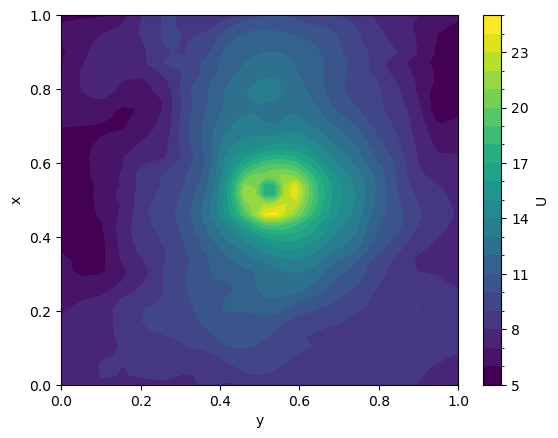

In [70]:
var = 'U'
data['AM2.5']['control']['tc_normalized_{0}'.format(var)] = tc_normalization(data['AM2.5']['control']['tc_model_output'], var=var)
data['AM2.5']['ktc']['tc_normalized_{0}'.format(var)] = tc_normalization(data['AM2.5']['ktc']['tc_model_output'], var=var)
(data['AM2.5']['control']['tc_normalized_{0}'.format(var)].mean('time')).plot.contourf(levels=24)

#### Storage and tests

In [ ]:
import dill
dill.dump_session('../backup/202304061347.db')
# dill.load_session('../backup/202303282020.db')  

Radius estimation "test unit". Iterates through storm IDs and gets radii.

In [ ]:
# model = 'AM2.5'
# experiment = 'control'
# storm_type = 'C15w'
# year_range = (101, 103)
# storm_track_output, model_output, storm_model_output = tc_storage(model, experiment, year_range, storm_type, random_num=10, benchmarking=True)

storms = storm_model_output.copy()

start = time.time()
N = 3

for storm_id in list(set(storms['storm_id'].values))[:N]:
    test_storm = storms.where(storms['storm_id'] == storm_id, drop=True).dropna(dim='grid_xt', how='all').dropna(dim='grid_yt', how='all')
    print(test_storm['storm_id'].values)
    print(radius_estimate(test_storm, box=15, overlay_check=False))
    print('--------------------')
    
print('Radius estimation runtime per storm: {0:.3f} s'.format((time.time() - start)/N))

# del model, experiment, storm_type, year_range, storm_track_output, model_output, storm_model_output, storm_id, test_storm, N

In [38]:
data['AM2.5']['ktc']['tc_model_output'].dropna(dim='grid_xt', how='all').dropna(dim='grid_yt', how='all')

<xarray.Dataset>
Dimensions:       (grid_yt: 60, grid_xt: 59, time: 3, bnds: 2)
Coordinates:
  * grid_yt       (grid_yt) float64 0.75 1.75 2.75 3.75 ... 47.25 48.25 49.25
  * grid_xt       (grid_xt) float64 74.06 75.31 75.94 ... 190.9 192.2 192.8
  * time          (time) object 0104-01-02 00:00:00 ... 0104-01-09 00:00:00
Dimensions without coordinates: bnds
Data variables: (12/22)
    grid_yt_bnds  (time, grid_yt, bnds) float64 nan nan nan nan ... nan nan nan
    grid_xt_bnds  (time, grid_xt, bnds) float64 nan nan nan ... 192.5 193.1
    vort850       (time, grid_yt, grid_xt) float32 nan nan nan ... nan nan nan
    tm            (time, grid_yt, grid_xt) float32 nan nan nan ... nan nan nan
    u_ref         (time, grid_yt, grid_xt) float32 nan nan nan ... nan nan nan
    v_ref         (time, grid_yt, grid_xt) float32 nan nan nan ... nan nan nan
    ...            ...
    core_temp     (time) float64 246.6 259.8 251.2
    speed         (time) float64 22.21 2.817 31.92
    heading       (time) float64 18.02 350.5 63.47
    storm_id      (time) object '2004-0001' '2007-0001' '2004-0002'
    U             (time, grid_yt, grid_xt) float32 nan nan nan ... nan nan nan
    radius        (time) float64 209.2 98.91 166.1
Attributes:
    filename:      atmos_4xdaily.tile1.nc
    title:         CM2.5_A_Control-1990_FLOR_B01
    grid_type:     regular
    grid_tile:     N/A
    history:       /tigress/wenchang/CM2.5_tiger2_wy/CM2.5/bin/fregrid_parall...
    code_version:  $Name: tikal_201409 $